In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))


/kaggle/input/extracting-attributes-from-fashion-images-2/sample_submission.csv
/kaggle/input/extracting-attributes-from-fashion-images-2/train.csv
/kaggle/input/extracting-attributes-from-fashion-images-2/test/Image_test_03058.jpg
/kaggle/input/extracting-attributes-from-fashion-images-2/test/Image_test_02479.jpg
/kaggle/input/extracting-attributes-from-fashion-images-2/test/Image_test_05379.jpg
/kaggle/input/extracting-attributes-from-fashion-images-2/test/Image_test_01202.jpg
/kaggle/input/extracting-attributes-from-fashion-images-2/test/Image_test_03064.jpg
/kaggle/input/extracting-attributes-from-fashion-images-2/test/Image_test_02787.jpg
/kaggle/input/extracting-attributes-from-fashion-images-2/test/Image_test_05731.jpg
/kaggle/input/extracting-attributes-from-fashion-images-2/test/Image_test_01752.jpg
/kaggle/input/extracting-attributes-from-fashion-images-2/test/Image_test_01615.jpg
/kaggle/input/extracting-attributes-from-fashion-images-2/test/Image_test_02208.jpg
/kaggle/inpu

# Importing Required Modules 

In [2]:
import pandas as pd
import cv2 as cv
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *
import os

/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: libtensorflow_io.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so: undefined symbol: _ZTVN10tenso

# Model Hyper parameters

In [3]:
train_path = "/kaggle/input/extracting-attributes-from-fashion-images-2/train"
BATCH_SIZE = 32
EPOCHS = 10

# Data Importing

In [4]:
# training data
train_df = pd.read_csv("/kaggle/input/extracting-attributes-from-fashion-images-2/train.csv")
train_df

,file_name,label
0,Image_train_00001.jpg,0
1,Image_train_00002.jpg,1
2,Image_train_00003.jpg,0
3,Image_train_00004.jpg,0
4,Image_train_00005.jpg,0
...,...,...
18386,Image_train_18387.jpg,1
18387,Image_train_18388.jpg,2
18388,Image_train_18389.jpg,1
18389,Image_train_18390.jpg,1


In [5]:
# testing data
test_df = pd.read_csv("/kaggle/input/extracting-attributes-from-fashion-images-2/sample_submission.csv")
test_df

,file_name,label
0,Image_test_00001.jpg,0
1,Image_test_00002.jpg,0
2,Image_test_00003.jpg,0
3,Image_test_00004.jpg,0
4,Image_test_00005.jpg,0
...,...,...
5746,Image_test_05747.jpg,0
5747,Image_test_05748.jpg,0
5748,Image_test_05749.jpg,0
5749,Image_test_05750.jpg,0


In [6]:
train_df.label.value_counts()

1    5384
2    4084
3    2008
4    1972
6    1925
5    1616
0    1402
Name: label, dtype: int64

In [7]:
test_df.label.value_counts()

0    5751
Name: label, dtype: int64

In [8]:
train_df.label.unique()

array([0, 1, 2, 3, 5, 4, 6])

In [9]:
from sklearn.utils import class_weight
class_weights = list(class_weight.compute_class_weight('balanced',
                                                 classes=np.unique(train_df.label.to_numpy()),
                                                 y=train_df.label.to_numpy()))
class_weights
# class_weight.compute_class_weight??

[1.8739555736702669,
 0.4879802589683719,
 0.6433118791101161,
 1.3084092202618098,
 1.3322949869603014,
 1.6257956152758133,
 1.3648237476808904]

In [10]:
weights = {x:y for x,y in enumerate(class_weights)}
weights

{0: 1.8739555736702669,
 1: 0.4879802589683719,
 2: 0.6433118791101161,
 3: 1.3084092202618098,
 4: 1.3322949869603014,
 5: 1.6257956152758133,
 6: 1.3648237476808904}

# Visualization the dataset

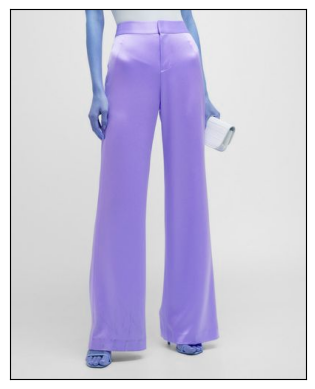

In [11]:
from matplotlib import pyplot as plt

train_files = os.listdir(train_path)
img = cv.imread(train_path+"/"+train_files[1])
plt.imshow(img)
plt.xticks([])
plt.yticks([])
plt.show()

In [12]:
# train_df.label = train_df.label.astype("str")
# train_df.label.dtype

# Creating Data Pipelines

In [13]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
datagen = ImageDataGenerator(
    rescale=1/255.0,
    rotation_range=20,
    zoom_range=0.05,
    width_shift_range=0.05,
    height_shift_range=0.05,
    shear_range=0.05,
    horizontal_flip=True,
    fill_mode = "nearest",
    validation_split=0.2
)

train_generator=datagen.flow_from_dataframe(
    dataframe=train_df,
    directory="/kaggle/input/extracting-attributes-from-fashion-images-2/train",
    x_col="file_name",
    y_col="label",
    subset="training",
    batch_size=BATCH_SIZE,
    seed=42,
    shuffle=True,
    class_mode="raw",
    target_size=(32,32))

valid_generator=datagen.flow_from_dataframe(
    dataframe=train_df,
    directory="/kaggle/input/extracting-attributes-from-fashion-images-2/train",
    x_col="file_name",
    y_col="label",
    subset="validation",
    batch_size=BATCH_SIZE,
    seed=42,
    shuffle=True,
    class_mode="raw",
    target_size=(32,32))



Found 14713 validated image filenames.
Found 3678 validated image filenames.


In [14]:
test_datagen=ImageDataGenerator(rescale=1./255.)

test_generator=test_datagen.flow_from_dataframe(
dataframe=test_df,
directory="/kaggle/input/extracting-attributes-from-fashion-images-2/test",
x_col="file_name",
y_col=None,
batch_size=BATCH_SIZE,
seed=42,
shuffle=False,
class_mode=None,
target_size=(32,32))

Found 5751 validated image filenames.


# Creating the Deep learning model

In [15]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *
from tensorflow import keras
model = Sequential()
model.add(Conv2D(32, (3, 3), padding='same',input_shape=(32,32,3)))
model.add(Activation('relu'))
model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dropout(0.5))

model.add(Dense(7, activation='softmax'))

model.compile(optimizer='rmsprop',loss="sparse_categorical_crossentropy",metrics=["accuracy"])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 32, 32, 32)        896       
                                                                 
 activation (Activation)     (None, 32, 32, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 30, 30, 32)        9248      
                                                                 
 activation_1 (Activation)   (None, 30, 30, 32)        0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 15, 15, 32)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 15, 15, 32)        0         
                                                        

Epoch 1/10


2023-05-31 05:24:18.094293: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


459/459 [==============================] - 153s 315ms/step - loss: 1.6772 - accuracy: 0.2674 - val_loss: 1.9564 - val_accuracy: 0.1494
Epoch 2/10
459/459 [==============================] - 70s 152ms/step - loss: 1.4664 - accuracy: 0.3629 - val_loss: 1.8341 - val_accuracy: 0.2177
Epoch 3/10
459/459 [==============================] - 75s 163ms/step - loss: 1.4024 - accuracy: 0.3828 - val_loss: 1.6982 - val_accuracy: 0.2752
Epoch 4/10
459/459 [==============================] - 76s 166ms/step - loss: 1.3613 - accuracy: 0.3920 - val_loss: 1.6877 - val_accuracy: 0.2708
Epoch 5/10
459/459 [==============================] - 78s 169ms/step - loss: 1.3369 - accuracy: 0.4108 - val_loss: 1.6539 - val_accuracy: 0.3117
Epoch 6/10
459/459 [==============================] - 71s 154ms/step - loss: 1.3171 - accuracy: 0.4150 - val_loss: 1.7261 - val_accuracy: 0.2601
Epoch 7/10
459/459 [==============================] - 79s 173ms/step - loss: 1.3037 - accuracy: 0.4231 - val_loss: 1.6042 - val_accuracy: 0.

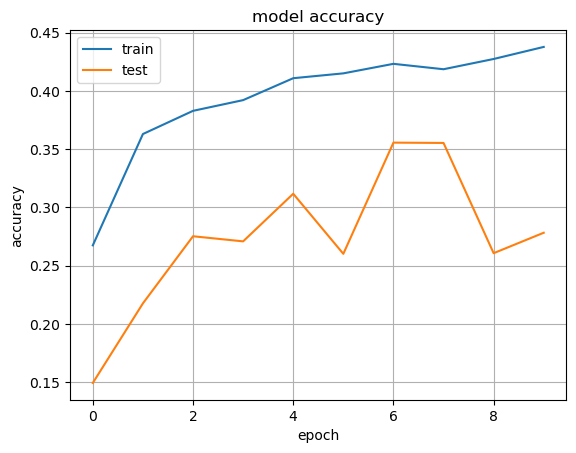

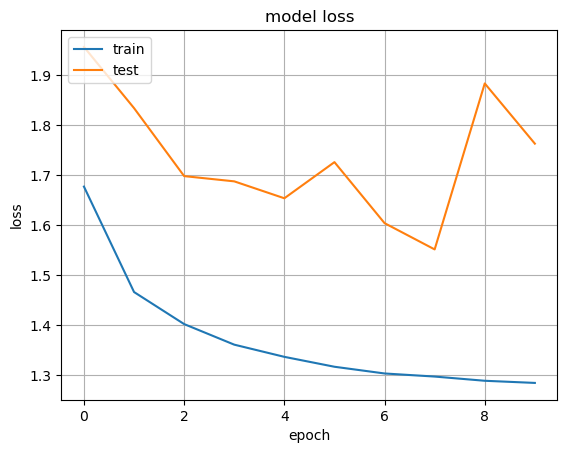

In [16]:
STEP_SIZE_TRAIN=train_generator.n//train_generator.batch_size
STEP_SIZE_VALID=valid_generator.n//valid_generator.batch_size
STEP_SIZE_TEST=test_generator.n//test_generator.batch_size

history = model.fit(train_generator,
                    steps_per_epoch=STEP_SIZE_TRAIN,
                    validation_data=valid_generator,
                    validation_steps=STEP_SIZE_VALID,
                    epochs=EPOCHS,
                   class_weight=weights)



print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.grid()
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.grid()
plt.show()

In [17]:
model.evaluate(valid_generator,
steps=STEP_SIZE_TEST)

179/179 [==============================] - 14s 81ms/step - loss: 1.7608 - accuracy: 0.2730


[1.7607955932617188, 0.27297443151474]

In [18]:
test_generator.reset()
pred=model.predict(test_generator,

verbose=1)

180/180 [==============================] - 33s 185ms/step


In [19]:
predicted_class_indices=np.argmax(pred,axis=1)
labels = {0:0,1:1,2:2,3:3,4:4,5:5,6:6}
labels = dict((v,k) for k,v in labels.items())
predictions = [labels[k] for k in predicted_class_indices]

In [20]:
pred.shape

(5751, 7)

In [21]:
predicted_class_indices

array([3, 2, 6, ..., 3, 0, 3])

In [22]:
from sklearn.metrics import confusion_matrix,accuracy_score
y_pred = predicted_class_indices
cm=confusion_matrix(test_df.label, y_pred)
print(cm)

accuracy_score(test_df.label.to_numpy(), y_pred)
# tn,fp,fn,tp = confusion_matrix(test_df.label, y_pred).ravel()

[[ 457  706  706 1761  258  831 1032]
 [   0    0    0    0    0    0    0]
 [   0    0    0    0    0    0    0]
 [   0    0    0    0    0    0    0]
 [   0    0    0    0    0    0    0]
 [   0    0    0    0    0    0    0]
 [   0    0    0    0    0    0    0]]


0.07946444096678838

In [23]:
251/5751

0.04364458355068684

In [24]:
filenames=test_generator.filenames
results=pd.DataFrame({"Filename":filenames,
                      "Predictions":predictions})
results.to_csv("submission.csv",index=False)